In [6]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

print("\nNonzero elements in H2:", np.count_nonzero(H2))

Hamiltonian matrix (dim=20):

Eigenvalues:
[1.06 1.23 2.   2.   2.14 2.68 3.   3.   3.   3.   3.   3.   3.   3.
 4.   4.   4.14 4.62 5.11 7.41]

Nonzero elements in H2: 144


In [7]:
import itertools
import numpy as np

all_basis = [tuple(int(x) for x in format(i, '06b')) for i in range(2**6)]

basis_index = [all_basis.index(b) for b in basis]

H_full = np.zeros((64, 64), dtype=complex)
for i, bi in enumerate(basis_index):
    for j, bj in enumerate(basis_index):
        H_full[bi, bj] = H[i, j]

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
paulis = [I, X, Y, Z]
labels = ['I','X','Y','Z']

coeffs = {}
for ops in itertools.product(range(4), repeat=6):
    P = paulis[ops[0]]
    for k in ops[1:]:
        P = np.kron(P, paulis[k])
    c = np.trace(P @ H_full) / 64
    if abs(c) > 1e-8:
        label = ''.join(labels[k] for k in ops)
        coeffs[label] = np.real_if_close(c)

print(f"\nNonzero Pauli terms ({len(coeffs)} terms):")
for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
    print(f"{k:10s} : {v:.6f}")



Nonzero Pauli terms (652 terms):
IIIIII     : 1.006250
ZZZZZZ     : -1.006250
IIZIIZ     : -0.218750
IZIIZI     : -0.218750
IZZIZZ     : 0.218750
ZIIZII     : -0.218750
ZIZZIZ     : 0.218750
ZZIZZI     : 0.218750
IIZIZI     : -0.212500
IZIIIZ     : -0.212500
ZIZZZI     : 0.212500
ZZIZIZ     : 0.212500
IZIZII     : -0.212500
ZIZIZZ     : 0.212500
IZZZIZ     : 0.212500
ZIIIZI     : -0.212500
IZZZZI     : 0.206250
ZIIIIZ     : -0.206250
IZIZZZ     : 0.206250
ZIZIII     : -0.206250
IIIZIZ     : -0.206250
ZZZIZI     : 0.206250
IZZIII     : -0.200000
ZIIZZZ     : 0.200000
IIIZZI     : -0.200000
ZZZIIZ     : 0.200000
IZZZZZ     : -0.193750
ZIIIII     : 0.193750
IIIIZI     : -0.187500
IZIIII     : 0.187500
ZIZZZZ     : -0.187500
ZZZZIZ     : 0.187500
IIIIIZ     : -0.181250
ZZZZZI     : 0.181250
IIZZII     : -0.168750
ZZIIZZ     : 0.168750
IIIIZZ     : -0.162500
ZZZZII     : 0.162500
IIZZZZ     : 0.162500
ZZIIII     : -0.162500
IIZIZZ     : 0.125000
ZZIZII     : -0.125000
IIIZZZ     : 0.125000

### Q-VAP

In [8]:
# Q-VAP for your 3-body Hamiltonian on 6 qubits
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit_algorithms.optimizers import COBYLA

def bcs_ansatz_thetas_tocircuit(thetas):
    qc = QuantumCircuit(6, name="BCS")
    for q, th in enumerate(thetas):
        qc.ry(2*th, q)
    return qc

def apply_qpe_projector(qc, n_ancillas, target_particles):
    sys_n = 6
    anc = QuantumRegister(n_ancillas, "anc")
    qc.add_register(anc)

    for a in range(n_ancillas):
        qc.h(sys_n + a)

    for j in range(n_ancillas):
        phi = 2 * np.pi * (2**j) / (2**n_ancillas)
        for q in range(sys_n):
            qc.cp(phi, sys_n + j, q)

    qft_inv = QFT(num_qubits=n_ancillas, inverse=True, do_swaps=True).to_gate(label="QFT^-1")
    qc.append(qft_inv, [sys_n + a for a in range(n_ancillas)])

    return qc

def project_statevector_onto_ancilla(statevec, n_ancillas, target_value):
    sys_n = 6
    nq = n_ancillas
    v = statevec.data
    dim_total = 1 << (sys_n + nq)
    dim_sys = 1 << sys_n
    out = np.zeros(dim_sys, dtype=complex)
    prob = 0.0

    for idx in range(dim_total):
        anc = 0
        for a in range(nq):
            anc |= (((idx >> (sys_n + a)) & 1) << a)
        if anc != target_value:
            continue
        sys_idx = 0
        for q in range(sys_n):
            sys_idx |= (((idx >> q) & 1) << q)
        amp = v[idx]
        out[sys_idx] += amp
        prob += (amp.conjugate() * amp).real

    if prob < 1e-16:
        return None, 0.0
    return out / np.sqrt(prob), prob


backend = Aer.get_backend("statevector_simulator")

def energy_expectation_with_qvap(thetas, H_full, n_ancillas=4, target_particles=3):
    qc = bcs_ansatz_thetas_tocircuit(thetas)
    qc = apply_qpe_projector(qc, n_ancillas, target_particles)

    psi = Statevector.from_instruction(qc)
    target_val = target_particles  
    psi_sys, p_succ = project_statevector_onto_ancilla(psi, n_ancillas, target_val)
    if psi_sys is None:
        return 1e6, 0.0
    E = float(np.real(np.vdot(psi_sys, H_full @ psi_sys)))
    return E, p_succ

def qvap_cost(theta_vec, H_full, n_ancillas=4, target_particles=3, w_post=0.0):
    E, p_succ = energy_expectation_with_qvap(theta_vec, H_full, n_ancillas, target_particles)
    if p_succ <= 1e-12:
        return 1e6
    return E + w_post * (-np.log(p_succ))

def run_qvap(H_full, n_ancillas=3, target_particles=3, maxiter=200, seed=0):
    rng = np.random.default_rng(seed)
    x0 = rng.uniform(low=0.2, high=1.2, size=6)

    try:
        from qiskit_algorithms.optimizers import COBYLA
        opt = COBYLA(maxiter=maxiter, tol=1e-4, rhobeg=0.3)
        minimize = opt.minimize
    except Exception:
        from scipy.optimize import minimize as scipy_minimize
        def minimize(fun, x0):
            return scipy_minimize(fun, x0, method="COBYLA", options={"maxiter": maxiter, "rhobeg": 0.3})

    history = []

    def _wrap_cost(x):
        val = qvap_cost(x, H_full, n_ancillas=n_ancillas, target_particles=target_particles, w_post=1e-2)
        history.append(val)
        return val

    res = minimize(fun=_wrap_cost, x0=x0)
    thetas = getattr(res, "x", np.asarray(res))

    E_final, p_succ = energy_expectation_with_qvap(thetas, H_full, n_ancillas, target_particles)
    out = {
        "thetas": np.asarray(thetas),
        "energy": E_final,
        "postselect_prob": p_succ,
        "nit": getattr(res, "nit", None),
        "nfev": getattr(res, "nfev", None),
        "fun": getattr(res, "fun", None),
        "status": getattr(res, "status", None),
        "message": getattr(res, "message", ""),
        "success": getattr(res, "success", True),
        "history": history,
    }
    return out



# ====== 実行例 ======
out = run_qvap(H_full, n_ancillas=4, target_particles=3, maxiter=200, seed=42)
print("Q-VAP energy      :", out["energy"])
print("postselect prob   :", out["postselect_prob"])
print("iters             :", out["nit"])
print("message           :", out["message"])
print("thetas (rad)      :", np.round(out["thetas"], 4))


/tmp/ipykernel_868665/3058062619.py:28: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_inv = QFT(num_qubits=n_ancillas, inverse=True, do_swaps=True).to_gate(label="QFT^-1")


Q-VAP energy      : 1.0693416233802229
postselect prob   : 0.475174593441144
iters             : None
message           : 
thetas (rad)      : [0.07 0.07 2.39 0.51 1.68 1.49]


In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation

def bcs_from_thetas(thetas):
    qc = QuantumCircuit(6, name="BCS(Q-VAP)")
    for q, th in enumerate(thetas):
        qc.ry(2*th, q)
    return qc

def amplitudes20_from_statevector(psi64, basis):
    coeffs = np.zeros(len(basis), dtype=complex)
    for idx, occ in enumerate(basis):
        sys_idx = 0
        for q, b in enumerate(occ):
            flipped_bit = 1 - int(b)
            sys_idx |= (flipped_bit << q)
        coeffs[idx] = psi64[sys_idx]
    nrm = np.linalg.norm(coeffs)
    if nrm < 1e-16:
        raise RuntimeError("Projected amplitude is (near) zero. Check thetas or projection.")
    return coeffs / nrm

def stateprep_from_qvap_thetas(thetas, basis, n_sys=5):
    psi64 = Statevector.from_instruction(bcs_from_thetas(thetas)).data
    psi20 = amplitudes20_from_statevector(psi64, basis)
    psi32 = np.zeros(2**n_sys, dtype=complex)
    psi32[:len(basis)] = psi20
    return StatePreparation(psi32)


### QPE

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT, StatePreparation, PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit_aer import Aer
import itertools

n_sys = 5
dim = len(basis)
evals, evecs = np.linalg.eigh(H)
eps = np.arange(num_orbitals) * delta
n_qubits = 8   # QPEの補助ビット数（そのまま）
shots = 1_000_000

# ---- 5量子ビット(=32次元)にHを埋め込む ----
def embed_H_to_5qubits(H20, n_sys=5):
    dim = H20.shape[0]
    H32 = np.zeros((2**n_sys, 2**n_sys), dtype=complex)
    H32[:dim, :dim] = H20
    return H32

# ---- 5量子ビットの Pauli 分解（全 4^5 = 1024 項）----
#   H = sum_P c_P P,  c_P = (1/2^n) Tr(P H)
#   係数の微小な虚部は丸めて実数化します（数値誤差対策）
def pauli_decompose_matrix(H32, n_sys=5, tol=1e-12):
    single = ['I','X','Y','Z']
    labels = []
    coeffs = []

    # 事前に単一量子ビットのパウリ行列を用意
    I = np.array([[1,0],[0,1]], dtype=complex)
    X = np.array([[0,1],[1,0]], dtype=complex)
    Y = np.array([[0,-1j],[1j,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    LUT = {'I': I, 'X': X, 'Y': Y, 'Z': Z}

    # 全パターンを列挙（n_sys=5なら1024通り）
    for tup in itertools.product(single, repeat=n_sys):
        label = ''.join(tup)  # 例: 'IXYZI'
        # 直積で行列を組む
        P = LUT[tup[0]]
        for s in tup[1:]:
            P = np.kron(P, LUT[s])
        c = np.trace(P @ H32) / (2**n_sys)
        # 数値誤差の虚部を抑える
        if abs(c.imag) < tol:
            c = c.real
        if np.abs(c) > tol:
            labels.append(label)
            coeffs.append(c)

    return SparsePauliOp.from_list(list(zip(labels, coeffs)))

# ---- HF初期状態（そのまま）----
def make_prep_hf_from_basis(basis, eps=None, hf_idx=None, n_sys=5):
    dim = len(basis)
    if hf_idx is None:
        e_cfg = [np.dot(np.array(s), np.array(eps)) for s in basis]
        hf_idx = int(np.argmin(e_cfg))
    psi20 = np.zeros(dim, dtype=complex); psi20[hf_idx] = 1.0
    psi32 = np.zeros(2**n_sys, dtype=complex); psi32[:dim] = psi20
    return StatePreparation(psi32), hf_idx

# ---- Trotter化 QPE 本体 ----
def qpe_spectrum_trotter(H_evals, H_matrix, basis, num_eval_qubits=8, shots=8192,
                         psi_prep=None, pad_frac=0.02, n_sys=5, trotter_reps=2):
    # ① スペクトル範囲と τ（あなたの元コードと同じスキーム）
    Emin = float(np.min(H_evals))
    Emax = float(np.max(H_evals))
    dE = Emax - Emin
    Emin_s = Emin - 0.5*pad_frac*dE
    Emax_s = Emax + 0.5*pad_frac*dE
    dE_s = Emax_s - Emin_s
    tau = 2*np.pi / dE_s  # これで (E - Emin_s) * tau ∈ [0, 2π)

    # ② H を 5量子ビットに埋めて Pauli 分解
    H32 = embed_H_to_5qubits(H_matrix, n_sys=n_sys)
    H_qubit = pauli_decompose_matrix(H32, n_sys=n_sys)

    # ③ シフト H' = H - Emin_s I を構成
    #    SparsePauliOp で恒等成分を調整
    id_label = 'I'*n_sys
    # 既存の恒等係数を探す
    coeffs = H_qubit.coeffs.copy()
    labels = list(H_qubit.to_list())  # [(label, coeff), ...]
    # to_list() は複製なので、この場で新しく作り直す方が簡単
    label_map = {lab: complex(c) for lab, c in labels}
    label_map[id_label] = label_map.get(id_label, 0.0) - Emin_s

    # 再度 SparsePauliOp 化（ゼロ近傍は落とす）
    labels2, coeffs2 = [], []
    for lab, c in label_map.items():
        if abs(c) > 1e-12:
            labels2.append(lab); coeffs2.append(c)
    H_shifted = SparsePauliOp.from_list(list(zip(labels2, coeffs2)))

    # ④ 量子回路（QPE）を構築：制御つき e^{-i H' τ 2^k} を Trotter で
    qr_anc = QuantumRegister(num_eval_qubits, "anc")
    qr_sys = QuantumRegister(n_sys, "sys")
    cr = ClassicalRegister(num_eval_qubits, "c")
    qc = QuantumCircuit(qr_anc, qr_sys, cr)

    if psi_prep is not None:
        qc.append(psi_prep, qr_sys)

    qc.h(qr_anc)

    synth = SuzukiTrotter(reps=trotter_reps)  # 1次Suzuki（=Trotter）; repsで分割数
    for k in range(num_eval_qubits):
        t_k = tau * (2**k)
        evol = PauliEvolutionGate(H_shifted, time=t_k, synthesis=synth)
        qc.append(evol.control(1), [qr_anc[k], *qr_sys])

    qc.append(QFT(num_eval_qubits, do_swaps=True).inverse(), qr_anc)
    qc.measure(qr_anc, cr)

    backend = Aer.get_backend("aer_simulator")
    res = backend.run(transpile(qc, backend), shots=shots).result()
    counts = res.get_counts()

    # ビット順（Qiskitの測定ビット順）を合わせるための反転はあなたの流儀に合わせて維持
    def invert_bits(b: str) -> str:
        return ''.join('1' if ch == '0' else '0' for ch in b)

    N = 2**num_eval_qubits
    spectrum = []
    for b, c in counts.items():
        b2 = invert_bits(b)
        k = int(b2, 2)
        phi = k / N
        E = Emin_s + dE_s * phi
        p = c / shots
        spectrum.append((E, p, b2))
    spectrum.sort(key=lambda x: x[0])

    return {
        "Emin": Emin, "Emax": Emax,
        "Emin_s": Emin_s, "Emax_s": Emax_s, "tau": tau,
        "counts": counts, "spectrum": spectrum, "circuit": qc
    }

thetas = out["thetas"]

prep_qvap = stateprep_from_qvap_thetas(thetas, basis, n_sys=n_sys)
out_qpe = qpe_spectrum_trotter(evals,
                       num_eval_qubits=n_qubits,
                       shots=10000000,
                       psi_prep=prep_qvap,
                          H_matrix=H,  
                          basis=basis,
                       pad_frac=1.03,
                       trotter_reps=5
                       )

print("τ_QPE:", out_qpe["tau"], "Scaled E-range:", (out_qpe["Emin_s"], out_qpe["Emax_s"]))
print("top lines of spectrum (E, prob, bitstring):")
for E, p, b in out_qpe["spectrum"][:10]:
    print(f"{E:.6f}", f"{p:.4e}", b)



/tmp/ipykernel_868665/2428463799.py:115: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_eval_qubits, do_swaps=True).inverse(), qr_anc)


τ_QPE: 0.4877770872409987 Scaled E-range: (-2.203841706162218, 10.677422034041342)
top lines of spectrum (E, prob, bitstring):
-2.203842 7.1000e-06 00000000
-2.153524 2.3100e-05 00000001
-2.103207 1.0260e-04 00000010
-2.052889 1.4300e-04 00000011
-2.002572 3.4950e-04 00000100
-1.952255 3.9320e-04 00000101
-1.901937 5.6360e-04 00000110
-1.851620 4.9230e-04 00000111
-1.801302 2.8860e-04 00001000
-1.750985 2.5560e-04 00001001


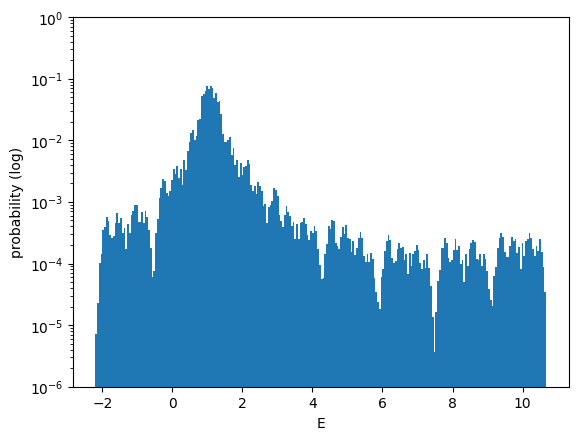

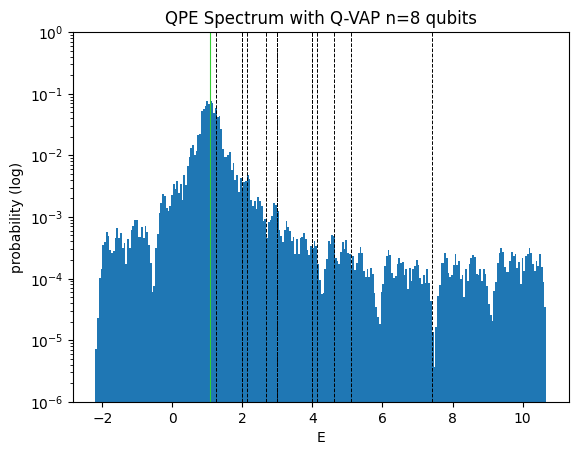

In [11]:
E_vals = [E for E, p, b in out_qpe["spectrum"]]
P_vals = [p for E, p, b in out_qpe["spectrum"]]

import matplotlib.pyplot as plt
bin_w = (out_qpe["Emax_s"]-out_qpe["Emin_s"]) / (2**n_qubits)

plt.bar(E_vals, P_vals, width=bin_w, align="edge")
plt.yscale("log")
plt.ylim(1e-6, 1e0)
plt.xlabel("E"); plt.ylabel("probability (log)")
plt.show()

for i, e in enumerate(evals):
    if i == 0:
        plt.axvline(e, color="limegreen", linestyle="-", linewidth=0.8, label="Exact GS")
    else:
        plt.axvline(e, color="black", linestyle="--", linewidth=0.7)

plt.title(f"QPE Spectrum with Q-VAP n={n_qubits} qubits")
plt.bar(E_vals, P_vals, width=bin_w, align="edge")
plt.yscale("log")
plt.ylim(1e-6, 1e0)
plt.xlabel("E"); plt.ylabel("probability (log)")
plt.show()

### Quantum Krylov

In [13]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

def bcs_from_thetas(thetas):
    qc = QuantumCircuit(6)
    for q, th in enumerate(thetas):
        qc.ry(2*th, q)
    return qc

def psi20_from_thetas(thetas, basis):
    psi64 = Statevector.from_instruction(bcs_from_thetas(thetas)).data
    coeffs = np.zeros(len(basis), dtype=complex)
    for idx, occ in enumerate(basis):
        sys_idx = 0
        for q, b in enumerate(occ):
            bit = int(b)       
            sys_idx |= (bit << q)
        coeffs[idx] = psi64[sys_idx]
    nrm = np.linalg.norm(coeffs)
    if nrm < 1e-16:
        raise RuntimeError("Projected amplitude is near zero. Check thetas/mapping.")
    return coeffs / nrm

def time_step_unitary(H, dt):
    evals, evecs = np.linalg.eigh(H)
    phases = np.exp(-1j * evals * dt)
    U = (evecs @ np.diag(phases) @ evecs.conj().T)
    return U

def build_krylov_states(H, psi0, M=8, dt=0.5):
    U = time_step_unitary(H, dt)
    states = [psi0]
    for _ in range(1, M):
        states.append(U @ states[-1])
    return states

def krylov_diagonalize(H, states):
    M = len(states)
    O = np.zeros((M, M), dtype=complex)
    Hs = np.zeros((M, M), dtype=complex)
    for i in range(M):
        for j in range(M):
            O[i, j]  = np.vdot(states[i], states[j])
            Hs[i, j] = np.vdot(states[i], H @ states[j])

    try:
        L = np.linalg.cholesky(O)
    except np.linalg.LinAlgError:
        eps = 1e-10
        L = np.linalg.cholesky(O + eps*np.eye(M))

    Linv  = np.linalg.inv(L)
    A = Linv @ Hs @ Linv.conj().T
    A = 0.5 * (A + A.conj().T)
    w, v = np.linalg.eigh(A)         
    c = Linv.conj().T @ v
    return w, c, O

def ritz_vectors(states, coeffs):
    M = len(states)
    r = coeffs.shape[1]
    dim = states[0].shape[0]
    vecs = np.zeros((dim, r), dtype=complex)
    S = np.stack(states, axis=1)  
    vecs = S @ coeffs             
    for k in range(r):
        nrm = np.linalg.norm(vecs[:, k])
        if nrm > 1e-14: vecs[:, k] /= nrm
    return vecs

def quantum_krylov_from_qvap(H20, basis, thetas, M=8, dt=0.5, top=10):
    psi0 = psi20_from_thetas(thetas, basis)
    states = build_krylov_states(H20, psi0, M=M, dt=dt)
    E_ritz, C, O = krylov_diagonalize(H20, states)
    order = np.argsort(E_ritz)
    E_ritz = E_ritz[order]
    C = C[:, order]
    V_ritz = ritz_vectors(states, C)

    evals_true, evecs_true = np.linalg.eigh(H20)
    match = []
    for Er in E_ritz[:top]:
        k = np.argmin(np.abs(evals_true - Er))
        match.append((Er, evals_true[k], abs(Er - evals_true[k])))
    return {
        "ritz_energies": E_ritz,
        "ritz_vectors": V_ritz,         
        "coeffs": C,                    
        "overlap_mat": O,
        "match_to_exact": match,
        "evals_true": evals_true
    }



res_k = quantum_krylov_from_qvap(H, basis, thetas, M=10, dt=0.4, top=12)

print("Ritz energies (first 12):")
for E in res_k["ritz_energies"][:12]:
    print(f"{E:.6f}")

print("\nNearest exacts and abs errors:")
for Er, Et, diff in res_k["match_to_exact"]:
    print(f"Ritz={Er:.6f} | Exact={Et:.6f} | |Δ|={diff:.3e}")


Ritz energies (first 12):
1.064051
1.234672
2.011902
2.140759
2.999614
3.981706
4.139086
4.618254
5.111107
7.409515

Nearest exacts and abs errors:
Ritz=1.064051 | Exact=1.064065 | |Δ|=1.392e-05
Ritz=1.234672 | Exact=1.234799 | |Δ|=1.273e-04
Ritz=2.011902 | Exact=2.000000 | |Δ|=1.190e-02
Ritz=2.140759 | Exact=2.140648 | |Δ|=1.113e-04
Ritz=2.999614 | Exact=3.000000 | |Δ|=3.862e-04
Ritz=3.981706 | Exact=4.000000 | |Δ|=1.829e-02
Ritz=4.139086 | Exact=4.139115 | |Δ|=2.877e-05
Ritz=4.618254 | Exact=4.618255 | |Δ|=8.259e-07
Ritz=5.111107 | Exact=5.111107 | |Δ|=1.412e-09
Ritz=7.409515 | Exact=7.409515 | |Δ|=1.126e-12
